# Whitebox attack using Privacy Meter

## Introduction

In this tutorial we will see:

- How to use the Privacy Meter to audit model implemented on Pytorch
- How to extract the white-box signal (i.e., gradient norm)
- How to run membership inference attack based on white-box attack based on the population attack

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/privacytrustlab/ml_privacy_meter/blob/master/tutorials/white_box_attack.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privacytrustlab/ml_privacy_meter/blob/master/tutorials/white_box_attack.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View GitHub</a>
  </td>
</table>

# Import

In [27]:
import numpy as np

import torch.nn.functional as F
from torch import nn
import torchvision
import os
import pickle
from ast import List
import time
import numpy as np
import torch
import torchvision
from torchvision import transforms

In [28]:
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.metric import PopulationMetric
from privacy_meter.information_source_signal import ModelGradientNorm, ModelGradient, ModelLoss
from privacy_meter.hypothesis_test import linear_itp_threshold_func
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import PytorchModelTensor

# Define hyper-parameters

In [29]:
# for training the target model
num_train_points = 5000
num_test_points = 5000
num_population_points = 10000
batch_size=64
learning_rate = 0.001
epochs=50

# Define the model

In [30]:

class Net(nn.Module):
    """Simple CNN for CIFAR10 dataset."""

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, inputs):
        """Forward pass of the model."""
        inputs = self.pool(F.relu(self.conv1(inputs)))
        inputs = self.pool(F.relu(self.conv2(inputs)))
        # flatten all dimensions except batch
        inputs = inputs.reshape(-1, 16 * 5 * 5)
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        outputs = self.fc3(inputs)
        return outputs
    

# Create the data

Load all the data

In [31]:
transform = transforms.Compose([transforms.ToTensor()])
all_data = torchvision.datasets.CIFAR10(
    root='.', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root='.', train=False, download=True, transform=transform
)
all_features = np.concatenate([all_data.data, test_data.data], axis=0)
all_targets = np.concatenate([all_data.targets, test_data.targets], axis=0)

all_data.data = all_features
all_data.targets = all_targets

Files already downloaded and verified
Files already downloaded and verified


Split the data into train, test and population

In [32]:
all_index = np.arange(len(all_data))
train_index = np.random.choice(all_index, num_train_points, replace=False)
test_index = np.random.choice([i for i in all_index if i not in train_index], num_test_points, replace=False)
population_index = np.random.choice([i for i in all_index if i not in train_index and i not in test_index], num_population_points, replace=False)

Create the data loader for training the target model

In [33]:
train_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(all_data,train_index),
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=16)
test_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(all_data,test_index),
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=16)

# Train the target model

In [36]:
model = Net()
device = 'cpu' # you can change it to 'cuda' if you have GPU
model.to(device)
model.train()

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
# Loop over each epoch
for epoch_idx in range(epochs):
    train_loss = 0
    # Loop over the training set
    for data, target in train_loader:
        # Move data to the device
        data, target = data.to(device, non_blocking=True), target.to(device,non_blocking=True)
        # Cast target to long tensor
        target = target.long()

        # Set the gradients to zero
        optimizer.zero_grad(set_to_none=True)

        # Get the model output
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Perform the backward pass
        loss.backward()
        # Take a step using optimizer
        optimizer.step()

        # Add the loss to the total loss
        train_loss += loss.item()

    # Print the epoch and loss summary
    print(f"Epoch: {epoch_idx+1}/{epochs} |", end=" ")
    print(f"Loss: {train_loss/len(train_loader):.8f}")

print("training the target model uses: ", time.time() - start_time)

# Validate the performance of the model 
model.eval()
# Assigning variables for computing loss and accuracy
loss, acc, criterion = 0, 0, nn.CrossEntropyLoss()

# Disable gradient calculation to save memory
with torch.no_grad():
    for data, target in train_loader:
        # Moving data and target to the device
        data, target = data.to(device), target.to(device)
        # Cast target to long tensor
        target = target.long()

        # Computing output and loss
        output = model(data)
        loss += criterion(output, target).item()

        # Computing accuracy
        pred = output.data.max(1, keepdim=True)[1]
        acc += pred.eq(target.data.view_as(pred)).sum()

    # Averaging the losses
    loss /= len(train_loader)

    # Calculating accuracy
    acc = float(acc) / len(train_loader.dataset)
    print("Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(loss, 100. * acc))

    for data, target in test_loader:
        # Moving data and target to the device
        data, target = data.to(device), target.to(device)
        # Cast target to long tensor
        target = target.long()

        # Computing output and loss
        output = model(data)
        loss += criterion(output, target).item()

        # Computing accuracy
        pred = output.data.max(1, keepdim=True)[1]
        acc += pred.eq(target.data.view_as(pred)).sum()

    # Averaging the losses
    loss /= len(test_loader)

    # Calculating accuracy
    acc = float(acc) / len(test_loader.dataset)
    print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(loss, 100. * acc))

# Move the model back to the CPU to save memory
model.to("cpu")




Epoch: 1/50 | Loss: 2.21932691
Epoch: 2/50 | Loss: 1.91558365
Epoch: 3/50 | Loss: 1.79438184
Epoch: 4/50 | Loss: 1.67080713
Epoch: 5/50 | Loss: 1.62384876
Epoch: 6/50 | Loss: 1.59812175
Epoch: 7/50 | Loss: 1.54739146
Epoch: 8/50 | Loss: 1.53910470
Epoch: 9/50 | Loss: 1.49032518
Epoch: 10/50 | Loss: 1.44806050
Epoch: 11/50 | Loss: 1.44459975
Epoch: 12/50 | Loss: 1.41474296
Epoch: 13/50 | Loss: 1.37183570
Epoch: 14/50 | Loss: 1.33535517
Epoch: 15/50 | Loss: 1.31236610
Epoch: 16/50 | Loss: 1.29817597
Epoch: 17/50 | Loss: 1.25635267
Epoch: 18/50 | Loss: 1.23293347
Epoch: 19/50 | Loss: 1.19884221
Epoch: 20/50 | Loss: 1.16003329
Epoch: 21/50 | Loss: 1.12182806
Epoch: 22/50 | Loss: 1.09693339
Epoch: 23/50 | Loss: 1.08800511
Epoch: 24/50 | Loss: 1.05695517
Epoch: 25/50 | Loss: 1.00201308
Epoch: 26/50 | Loss: 1.00469009
Epoch: 27/50 | Loss: 0.94503378
Epoch: 28/50 | Loss: 0.95994923
Epoch: 29/50 | Loss: 0.88732846
Epoch: 30/50 | Loss: 0.87197132
Epoch: 31/50 | Loss: 0.84926866
Epoch: 32/50 | Lo

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Wrap the target model and datasets
The `batch_size` parameter determines the number of samples used in each iteration when computing the signals. Larger batch sizes can increase computation speed, but they also consume more memory. If you're computing the loss, you can use a larger batch size, but if you're using the GPU to compute gradient information such as gradient norm, using a batch size that is too large may result in an Out Of Memory (OOM) error. This is largely dependent on the size of your model and the memory capacity of your GPU. As a general guideline, we recommend using a batch size of 10 when computing gradient information

In [45]:

target_model = PytorchModelTensor(model_obj=model, loss_fn=criterion, device=device,batch_size=10)

Get the dataset in the tensor formate

In [38]:

def get_dataset_subset(dataset: torchvision.datasets, index: List(int)):
    """Get a subset of the dataset.

    Args:
        dataset (torchvision.datasets): Whole dataset.
        index (list): List of index.
    """
    assert max(index) < len(dataset) and min(index) >= 0, "Index out of range"
    data = (
        torch.from_numpy(dataset.data[index]).float().permute(0, 3, 1, 2) / 255
    )  # channel first
    targets = list(np.array(dataset.targets)[index])
    targets = torch.tensor(targets, dtype=torch.long)
    return data, targets

In [39]:
train_data, train_targets = get_dataset_subset(all_data, train_index)
test_data, test_targets = get_dataset_subset(all_data, test_index)
audit_data, audit_targets = get_dataset_subset(all_data, population_index)
target_dataset = Dataset(
    data_dict={
        "train": {"x": train_data, "y": train_targets},
        "test": {"x": test_data, "y": test_targets},
    },
    default_input="x",
    default_output="y",
)


audit_dataset = Dataset(
        data_dict={"train": {"x": audit_data, "y": audit_targets}},
        default_input="x",
        default_output="y",
    )
 


# Create Information Sources

In [ ]:
target_info_source = InformationSource(
    models=[target_model], 
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[audit_dataset]
)

# Metric and Audit 
We assess the privacy risk of our trained model using a population attack that is based on both the loss of the target model and the gradient norm of the target model. The results based on the loss indicate the privacy risk of the model in a black-box setting, where the adversary does not have access to the entire model. Conversely, computing the gradient norm per sample requires the adversary to have access to the entire model parameters, which corresponds to a white-box setting.

In [40]:
metric = PopulationMetric(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )
audit_obj = Audit(
    metrics=metric,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
)
audit_obj.prepare()
loss_audit_results = audit_obj.run()[0]

Results are stored in: ['/home/hongyan/Desktop/ml_privacy_test/ml_privacy_meter/tutorials/log_2023-02-10_13-51-49-000']


In [41]:
metric = PopulationMetric(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=[ModelGradientNorm()],
            hypothesis_test_func=linear_itp_threshold_func,
        )
audit_obj = Audit(
    metrics=metric,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
)
audit_obj.prepare()
gradient_norm_audit_results = audit_obj.run()[0]

/home/hongyan/.conda/envs/privacy_meter_test/lib/python3.9/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Results are stored in: ['/home/hongyan/Desktop/ml_privacy_test/ml_privacy_meter/tutorials/log_2023-02-10_13-51-51-000']


# Compare the results

In [42]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

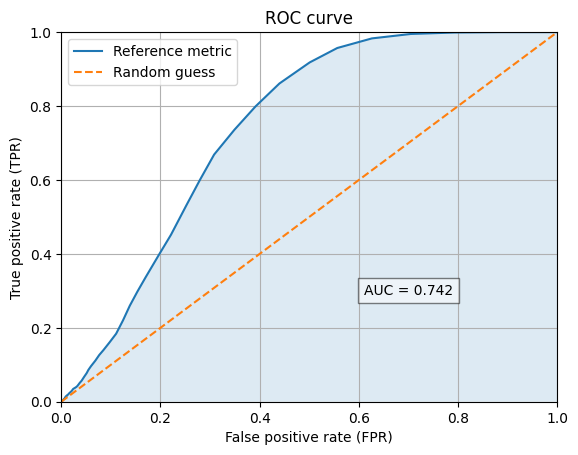

<Figure size 640x480 with 0 Axes>

In [43]:
ROCCurveReport.generate_report(
    metric_result=loss_audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

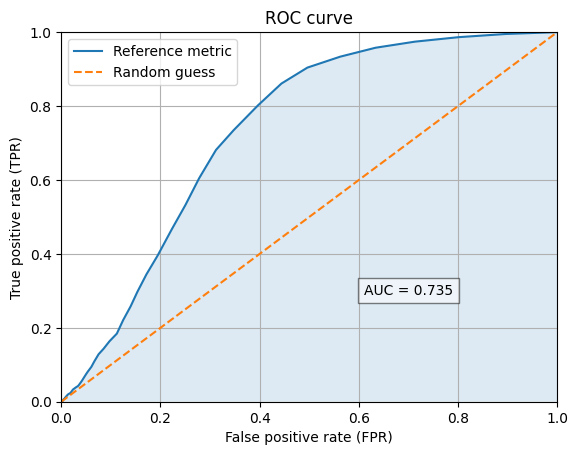

<Figure size 640x480 with 0 Axes>

In [44]:
ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)